In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import os

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn
import teotil3 as teo
from sqlalchemy import text

plt.style.use("ggplot")

In [3]:
# Connect to JupyterHub's PostGIS database
eng = nivapy.da.connect_postgis()

Connection successful.


# Task 2.15: Testing, documentation and reporting

## Part E: Mjøsa

Checking measured fluxes around Mjøsa against predictions from TEOTIL3.

## 1. Raw chemistry data

We have long-term chemistry data (starting before 1990) for 6 rivers flowing into Mjøsa, including the main inflow (Lågen). We also have chemistry data collected from the outflow (Vorma) from 2010 onwards.

In general terms, the Lågen catchment (i.e. the main inflow) is mountainous and overall it is less affected by human activities than the five smaller inflows, which support extensive agriculture. There are also many smaller rivers flowing into Mjøsa where we do not have monitoring data.

Jan-Erik has supplied an Excel file of water chemistry data for the period until the end of 2022.

### 1.1. Read basic data

In [4]:
# Read data from Jan-Erik
xl_path = r"../../data/mjosa_data.xlsx"
stn_df = pd.read_excel(xl_path, sheet_name="stations")
wc_df = pd.read_excel(xl_path, sheet_name="concentrations")
sk_df = pd.read_excel(xl_path, sheet_name="skreia")

print("Water chemsitry data:")
display(wc_df.head())

print("Station details:")
display(stn_df)

Water chemsitry data:


,site_id,site_name,date,TOTP_ug/l,TOTN_ug/l
0,1,Flagstadelva,1987-01-22,9.0,2965.0
1,1,Flagstadelva,1987-02-24,8.0,2585.0
2,1,Flagstadelva,1987-03-16,11.0,3134.0
3,1,Flagstadelva,1987-04-07,106.0,5359.0
4,1,Flagstadelva,1987-04-21,59.0,4530.0


Station details:


,site_id,site_name,type,longitude,latitude,nve_dis_stn_id,regine,comment
0,1,Flagstadelva,minor inflow,11.10400,60.81550,2.323.0,002.DC5A0,NVE station on a different river
1,2,Gausa,minor inflow,10.39090,61.15800,2.28.0,002.DDA0,NaN
2,3,Hunnselva,minor inflow,10.69498,60.79415,2.634.0,002.DCA1,NaN
3,4,Lenaelva,minor inflow,10.95474,60.65725,2.634.0,002.DC4A0,NVE station on a different river
4,5,Lågen,main inflow,10.39530,61.16270,2.145.0,002.DE1,NaN
5,6,Svartelva,minor inflow,11.15240,60.78510,2.464.0,002.DC3A0,Monitoring station mid-regine upstream of trib...
6,7,Vorma,main outflow,11.23370,60.39760,2.197.0,002.DC11,NaN


In [5]:
# NVE have removed discharge data for Gausa, so omit for now
stn_df = stn_df.query("site_id != 2").reset_index(drop=True)
wc_df = wc_df.query("site_id != 2").reset_index(drop=True)

In [6]:
wc_df = wc_df.query("date >= '2013-01-01'")

# Reshape to 'long'
id_cols = ["site_id", "site_name", "date"]
pars = ["TOTP_ug/l", "TOTN_ug/l"]
df = wc_df[id_cols + pars].copy()
df = df.melt(id_vars=id_cols, var_name="parameter").dropna()

# Test each series for outliers
df_list = []
stn_list = df["site_id"].unique().tolist()

for stn_id in stn_list:
    for par in pars:
        stn_par_df = df.query("(site_id == @stn_id) and (parameter == @par)").copy()
        if len(stn_par_df) > 0:
            stn_par_df["outlier"] = nivapy.stats.double_mad_from_median(
                stn_par_df["value"], thresh=3
            )
            df_list.append(stn_par_df)
df = pd.concat(df_list)
df.head()

,site_id,site_name,date,parameter,value,outlier
0,1,Flagstadelva,2013-01-18,TOTP_ug/l,16.0,False
1,1,Flagstadelva,2013-02-15,TOTP_ug/l,14.0,False
2,1,Flagstadelva,2013-03-06,TOTP_ug/l,9.2,False
3,1,Flagstadelva,2013-03-20,TOTP_ug/l,8.2,False
4,1,Flagstadelva,2013-03-26,TOTP_ug/l,8.8,False


In [7]:
len(wc_df)

1314

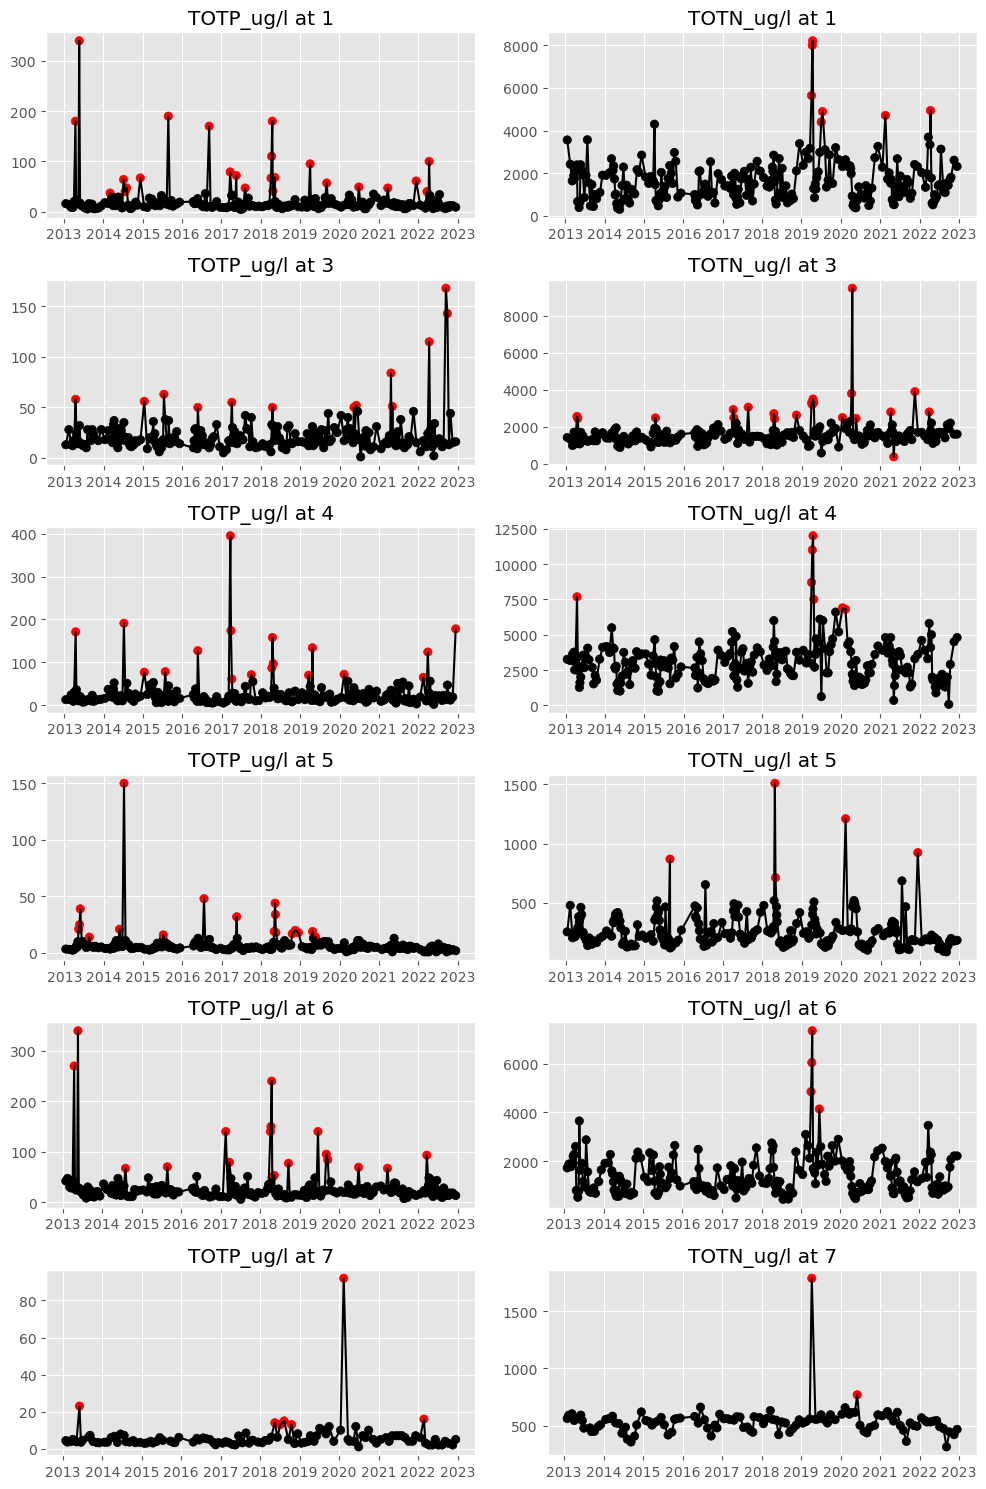

In [8]:
fig, axes = plt.subplots(nrows=len(stn_list), ncols=2, figsize=(10, 15))

for row_idx, stn_id in enumerate(stn_list):
    for col_idx, par in enumerate(pars):
        stn_par_df = df.query("(site_id == @stn_id) and (parameter == @par)").copy()
        stn_par_df.sort_values("date", inplace=True)
        stn_par_df["outlier_col"] = ["r" if i else "k" for i in stn_par_df["outlier"]]
        axes[row_idx, col_idx].plot(stn_par_df["date"], stn_par_df["value"], "k-")
        axes[row_idx, col_idx].scatter(
            stn_par_df["date"],
            stn_par_df["value"],
            c=stn_par_df["outlier_col"].tolist(),
        )
        axes[row_idx, col_idx].set_title(f"{par} at {stn_id}")
plt.tight_layout()

In [9]:
df = (
    df.query("outlier == False")
    .drop(columns="outlier")
    .set_index(["site_id", "site_name", "date", "parameter"])
    .unstack("parameter")
)
df.columns = df.columns.get_level_values(1)
wc_df = df.reset_index()

## 2. Catchment boundaries for water chemistry sites

The first step is to generate catchment boundaries for the water chemistry monitoring locations.

In [10]:
wc_gdf = nivapy.spatial.derive_watershed_boundaries(
    stn_df,
    id_col="site_id",
    xcol="longitude",
    ycol="latitude",
    crs="epsg:4326",
    min_size_km2=100,
    dem_res_m=40,
    buffer_km=None,
    temp_fold=None,
    reproject=False,
)

Connection successful.


Looping over vassdragsområder:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 002:   0%|          | 0/6 [00:00<?, ?it/s]

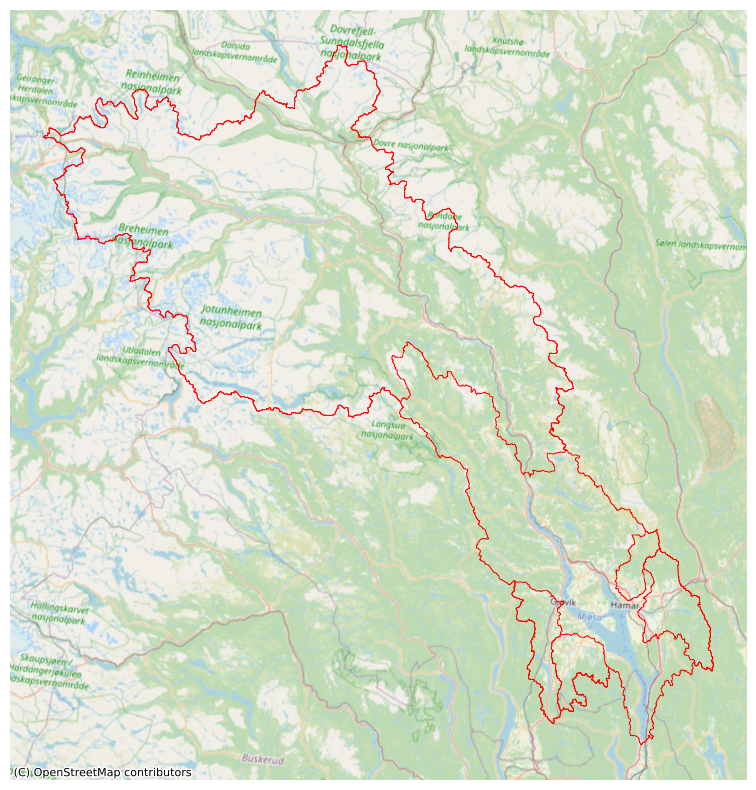

In [11]:
# Plot
ax = wc_gdf.plot(figsize=(10, 10), edgecolor="r", facecolor="none")
cx.add_basemap(ax, crs=wc_gdf.crs, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

## 3. Get NVE discharge

I have used NVE Atlas to identify appropriate discharge monitoring stations for each chemistry site. The NVE site selection is slightly different to that used previous in Mjøsa reports, but I think it is reasonable.

In [12]:
# Get par ID for discharge
par_df = nivapy.da.get_nve_hydapi_parameters()
par_df = par_df.query("parameterName == 'Vannføring'")
par_df

,parameter,parameterName,parameterNameEng,unit
2,1001,Vannføring,Discharge,m³/s


In [13]:
# Get NVE stations
nve_ids = stn_df["nve_dis_stn_id"].unique().tolist()
nve_stn_df = nivapy.da.get_nve_hydapi_stations()
nve_stn_df = nve_stn_df.query("station_id in @nve_ids")
nve_stn_df

,station_id,station_name,latitude,longitude,utmEast_Z33,utmNorth_Z33,masl,riverName,councilNumber,councilName,...,culQ5,culQ10,culQ20,culQ50,culHm,culH5,culH10,culH20,culH50,seriesList
813,2.145.0,Losna,61.33339,10.27753,247417,6809063,183,Vorma-Lågen,3440,Øyer,...,1615.0000,1834.0000,2049.0000,2332.0000,182.5200,182.9800,183.3500,183.7000,184.1300,"[{'parameterName': 'Vannstand', 'parameter': 1..."
821,2.197.0,Ertesekken ndf.,60.20104,11.37319,299002,6679325,122,Vorma-Lågen,3228,Nes,...,1120.0000,1260.0000,1410.0000,1610.0000,NaN,NaN,NaN,NaN,NaN,"[{'parameterName': 'Vannføring', 'parameter': ..."
864,2.323.0,Fura,60.88483,11.32496,300585,6755550,350,Fura,3412,Løten,...,24.9431,28.8821,32.7342,37.8297,1.3768,1.5227,1.6363,1.7398,1.8676,"[{'parameterName': 'Vannstand', 'parameter': 1..."
900,2.464.0,Svartelva,60.77604,11.18649,292373,6743875,138,Svartelvvassdraget,3403,Hamar,...,103.6275,121.2718,136.7540,154.8900,2.4796,2.7163,2.8546,2.9669,3.0897,"[{'parameterName': 'Vannstand', 'parameter': 1..."
923,2.634.0,Lena,60.67131,10.81131,271220,6733473,224,Lenaelva,3442,Østre Toten,...,46.3381,58.5875,72.6660,95.0154,221.5836,221.7454,221.9332,222.1270,222.4009,"[{'parameterName': 'Vannstand', 'parameter': 1..."


In [14]:
# Get discharge data
par_ids = [1001]
st_dt = "1980-01-01"
end_dt = "2023-01-01"
q_df = nivapy.da.query_nve_hydapi(nve_ids, par_ids, st_dt, end_dt, resolution=1440)
q_df.head()

,station_id,station_name,parameter,parameter_name,parameter_name_eng,method,datetime,value,unit,correction,quality
0,2.197.0,Ertesekken ndf.,1001,Vannføring,Discharge,Instantaneous,1980-01-01 11:00:00+00:00,154.0,m³/s,0,3
1,2.197.0,Ertesekken ndf.,1001,Vannføring,Discharge,Instantaneous,1980-01-02 11:00:00+00:00,248.0,m³/s,0,3
2,2.197.0,Ertesekken ndf.,1001,Vannføring,Discharge,Instantaneous,1980-01-03 11:00:00+00:00,270.0,m³/s,0,3
3,2.197.0,Ertesekken ndf.,1001,Vannføring,Discharge,Instantaneous,1980-01-04 11:00:00+00:00,267.0,m³/s,0,3
4,2.197.0,Ertesekken ndf.,1001,Vannføring,Discharge,Instantaneous,1980-01-05 11:00:00+00:00,247.0,m³/s,0,3


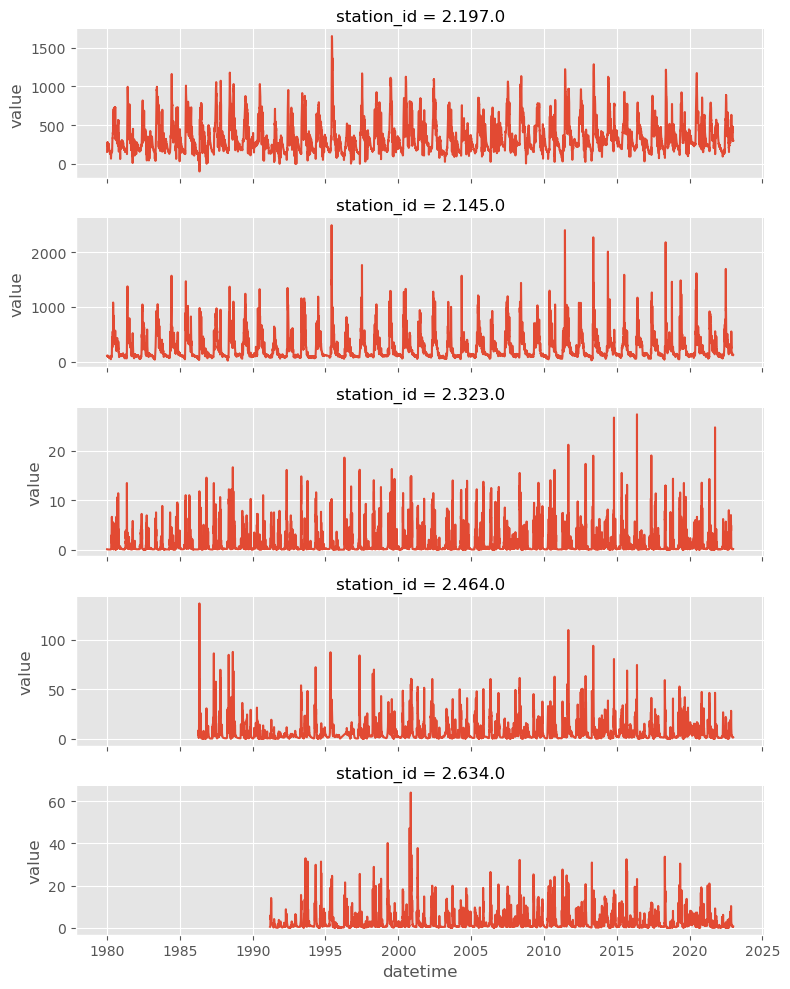

In [15]:
# Plot
sn.relplot(
    data=q_df,
    x="datetime",
    y="value",
    row="station_id",
    kind="line",
    aspect=4,
    height=2,
    facet_kws={"sharey": False, "sharex": True},
)

In [16]:
# Linearly interpolate NoData gaps (i.e. where valid values exist either side of gap),
# but no extrapolation. ALso limit to period where we have complete data for all sites
q_df = (
    q_df.pivot(columns="station_id", index="datetime", values="value")
    .resample("D")
    .mean()
    .interpolate(method="linear", limit_area="inside")
    .dropna(how="any")
)

# Remove time zone info
q_df.index = q_df.index.tz_localize(None)

q_df.head()

station_id,2.145.0,2.197.0,2.323.0,2.464.0,2.634.0
datetime,,,,,
1991-03-12,81.67283,145.0,0.157021,0.594957,0.531040
1991-03-13,76.27954,145.0,0.169012,0.594957,0.582352
1991-03-14,80.30379,145.0,0.194607,0.544122,0.582352
1991-03-15,84.45259,143.0,0.208225,0.544122,0.636984
1991-03-16,84.45259,141.0,0.208225,0.496286,0.636984


## 4. Catchment boundaries for discharge sites

The code below generates catchment boundaries for the discharge sites. These can then be used to area-scale discharges to match the chemistry monitoring locations.

In [17]:
q_gdf = nivapy.spatial.derive_watershed_boundaries(
    nve_stn_df,
    id_col="station_id",
    xcol="longitude",
    ycol="latitude",
    crs="epsg:4326",
    min_size_km2=100,
    dem_res_m=40,
    buffer_km=None,
    temp_fold=None,
    reproject=False,
)

Connection successful.


Looping over vassdragsområder:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 002:   0%|          | 0/5 [00:00<?, ?it/s]

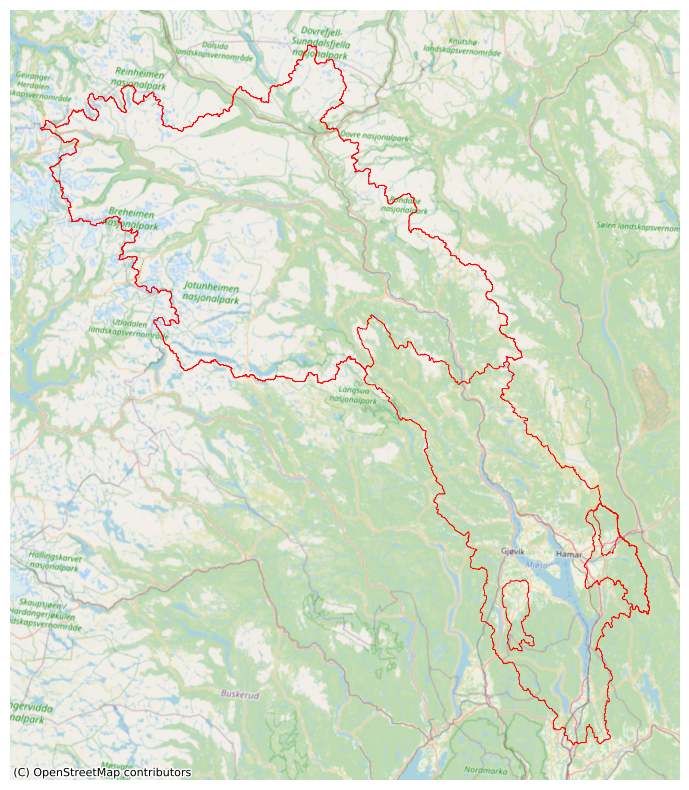

In [18]:
# Plot
ax = q_gdf.plot(figsize=(10, 10), edgecolor="r", facecolor="none")
cx.add_basemap(ax, crs=q_gdf.crs, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

## 5. Area-scale flows

For 5 out of 7 rivers, NVE has discharge monitoring for the period of interest from somewhere within the same catchment. Two rivers have no discharge monitoring (see `stn_df` in Section 1), so I'll have to scale the discharge from a neighbouring catchment instead.

In [19]:
# Calculate catchment areas and join chem to dis data
wc_gdf["area_km2"] = wc_gdf.to_crs({"proj": "cea"})["geometry"].area / 1e6
q_gdf["area_km2"] = q_gdf.to_crs({"proj": "cea"})["geometry"].area / 1e6
q_gdf.rename({"station_id": "nve_dis_stn_id"}, axis="columns", inplace=True)
wc_gdf = wc_gdf.merge(
    q_gdf[["nve_dis_stn_id", "area_km2"]],
    how="left",
    on="nve_dis_stn_id",
    suffixes=["_chem", "_dis"],
)
wc_gdf

,site_id,geometry,site_name,type,longitude,latitude,nve_dis_stn_id,regine,comment,area_km2_chem,area_km2_dis
0,1,"POLYGON ((296360 6771520, 296360 6771480, 2963...",Flagstadelva,minor inflow,11.10400,60.81550,2.323.0,002.DC5A0,NVE station on a different river,173.094835,106.906583
1,3,"MULTIPOLYGON (((249840 6754320, 249960 6754320...",Hunnselva,minor inflow,10.69498,60.79415,2.634.0,002.DCA1,None,372.485691,182.260021
2,4,"POLYGON ((269160 6737240, 269160 6737200, 2690...",Lenaelva,minor inflow,10.95474,60.65725,2.634.0,002.DC4A0,NVE station on a different river,292.341697,182.260021
3,5,"MULTIPOLYGON (((262280 6804000, 262240 6804000...",Lågen,main inflow,10.39530,61.16270,2.145.0,002.DE1,None,11445.867993,11088.164388
4,6,"MULTIPOLYGON (((310200 6747080, 310200 6747040...",Svartelva,minor inflow,11.15240,60.78510,2.464.0,002.DC3A0,Monitoring station mid-regine upstream of trib...,481.605114,464.295884
5,7,"MULTIPOLYGON (((255000 6731400, 255040 6731400...",Vorma,main outflow,11.23370,60.39760,2.197.0,002.DC11,None,16439.819100,17379.338172


In [20]:
# Scale flows to match chem sites
for idx, row in wc_gdf.iterrows():
    nve_id = row["nve_dis_stn_id"]
    area_fac = row["area_km2_chem"] / row["area_km2_dis"]
    q_df[nve_id] = area_fac * q_df[nve_id]
q_df.head()

station_id,2.145.0,2.197.0,2.323.0,2.464.0,2.634.0
datetime,,,,,
1991-03-12,84.307591,137.161366,0.254236,0.617138,1.740784
1991-03-13,78.740314,137.161366,0.273652,0.617138,1.908987
1991-03-14,82.894386,137.161366,0.315092,0.564407,1.908987
1991-03-15,87.177026,135.269485,0.337142,0.564407,2.088076
1991-03-16,87.177026,133.377604,0.337142,0.514788,2.088076


## 6. Estimate fluxes

I will initially estimate fluxes using four different methods to get an idea of method-induced uncertainty. Note:

 * We only have chemistry data for Vorma from 2010 onwards. 
 
 * We only have point data (sewage and industry) up to 2021. 
 
I will therefore restrict the flux calculations to the period from 2010 to 2021.

In [21]:
# Period for flux calculations
st_yr, end_yr = 2013, 2021

In [22]:
df_list = []
for method in [
    # "linear_interpolation",
    # "simple_means",
    # "log_log_linear_regression",
    "ospar_annual",
]:
    for idx, row in wc_gdf.iterrows():
        name = row["site_name"]
        chem_id = row["site_id"]
        dis_id = row[["nve_dis_stn_id"]]
        site_wc_df = (
            wc_df.query("site_id == @chem_id")
            .copy()
            .set_index("date")[["TOTP_ug/l", "TOTN_ug/l"]]
            .resample("D")
            .mean()
        )
        site_q_df = q_df[dis_id]
        site_q_df.columns = ["flow_m3/s"]

        flux_df = nivapy.stats.estimate_fluxes(
            site_q_df,
            site_wc_df,
            base_freq="D",
            agg_freq="A",
            method=method,
            st_date=f"{st_yr}-01-01",
            end_date=f"{end_yr}-12-31",
            plot_fold=None,
        )
        flux_df["site_id"] = chem_id
        flux_df["name"] = name
        flux_df["method"] = method

        if method != "ospar_annual":
            del flux_df["flow_m3"]
            flux_df["year"] = flux_df.index.year
            flux_df.reset_index(inplace=True, drop=True)
        else:
            flux_df.reset_index(inplace=True)

        df_list.append(flux_df)

flux_df = pd.concat(df_list, axis="rows")

# Convert kgs to tonnes
for col in ["TOTP_kg", "TOTN_kg"]:
    par = col.split("_")[0]
    flux_df[f"{par}_tonnes"] = flux_df[col] / 1000
    del flux_df[col]

flux_df.drop(columns=["method"], inplace=True)

flux_df = pd.merge(flux_df, stn_df[["site_id", "regine"]], how="left", on="site_id")

flux_df.head()

/opt/conda/lib/python3.11/site-packages/nivapy3/stats.py:753: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  ann_q_df = (df[["flow_m3/s"]] * 24 * 60 * 60).resample("A").sum()
/opt/conda/lib/python3.11/site-packages/nivapy3/stats.py:753: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  ann_q_df = (df[["flow_m3/s"]] * 24 * 60 * 60).resample("A").sum()
/opt/conda/lib/python3.11/site-packages/nivapy3/stats.py:753: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  ann_q_df = (df[["flow_m3/s"]] * 24 * 60 * 60).resample("A").sum()
/opt/conda/lib/python3.11/site-packages/nivapy3/stats.py:753: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  ann_q_df = (df[["flow_m3/s"]] * 24 * 60 * 60).resample("A").sum()
/opt/conda/lib/python3.11/site-packages/nivapy3/stats.py:753: FutureWarning: 'A' is 

,year,site_id,name,TOTP_tonnes,TOTN_tonnes,regine
0,2013,1,Flagstadelva,0.728695,73.838574,002.DC5A0
1,2014,1,Flagstadelva,1.285104,64.274324,002.DC5A0
2,2015,1,Flagstadelva,0.954445,82.075821,002.DC5A0
3,2016,1,Flagstadelva,0.810371,45.931036,002.DC5A0
4,2017,1,Flagstadelva,1.013915,54.389096,002.DC5A0


## 7. Model results

In [23]:
nve_data_year = 2023
st_yr, end_yr = 2013, 2022
eval_fold = r"/home/jovyan/shared/common/teotil3/evaluation"

In [24]:
# Read saved data for speed
mod_csv = os.path.join(
    eval_fold, f"teo3_results_nve{nve_data_year}_{st_yr}-{end_yr}.csv"
)
mod_df = pd.read_csv(mod_csv)
mod_df.head()

,regine,regine_down,accum_agriculture-background_din_kg,accum_agriculture-background_ss_kg,accum_agriculture-background_tdp_kg,accum_agriculture-background_toc_kg,accum_agriculture-background_ton_kg,accum_agriculture-background_totn_kg,accum_agriculture-background_totp_kg,accum_agriculture-background_tpp_kg,...,local_urban_tpp_kg,local_wood_din_kg,local_wood_ss_kg,local_wood_tdp_kg,local_wood_toc_kg,local_wood_ton_kg,local_wood_totn_kg,local_wood_totp_kg,local_wood_tpp_kg,year
0,001.10,001.,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,36.1,849.2,0.6,9938.9,186.2,222.3,5.4,4.8,2013
1,001.1A2B,001.1A2A,123.574401,0.752367,3.420677,6341.957239,68.505729,192.080130,3.609359,0.188682,...,5.6,1318.1,29798.4,23.9,384175.8,7138.8,8456.9,210.0,186.1,2013
2,001.1A4D,001.1A4C,15.917595,0.289332,0.117126,464.712746,6.729665,22.647261,0.149627,0.032501,...,0.0,237.2,5272.5,4.3,70016.3,1296.4,1533.6,38.2,33.9,2013
3,001.1M,001.1L,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,473.5,11104.0,8.8,142788.5,2641.6,3115.1,78.3,69.5,2013
4,001.21,001.,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,5.0,117.0,0.1,1386.1,25.9,30.9,0.8,0.7,2013


In [25]:
def remove_prefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix) :]
    return text


# Tidy modelled data for comparison
cols = [col for col in mod_df.columns if col.startswith("accum_")]
mod_df = mod_df[["regine", "year"] + cols].copy()
cols = [remove_prefix(col, "accum_") for col in cols]
mod_df.columns = ["regine", "year"] + cols
for col in cols:
    if col.endswith("_kg"):
        mod_df[col[:-3] + "_tonnes"] = mod_df[col] / 1000
    del mod_df[col]

# Merge
comp_df = pd.merge(flux_df, mod_df, how="left", on=["regine", "year"])
comp_df.head()

,year,site_id,name,TOTP_tonnes,TOTN_tonnes,regine,agriculture-background_din_tonnes,agriculture-background_ss_tonnes,agriculture-background_tdp_tonnes,agriculture-background_toc_tonnes,...,urban_totp_tonnes,urban_tpp_tonnes,wood_din_tonnes,wood_ss_tonnes,wood_tdp_tonnes,wood_toc_tonnes,wood_ton_tonnes,wood_totn_tonnes,wood_totp_tonnes,wood_tpp_tonnes
0,2013,1,Flagstadelva,0.728695,73.838574,002.DC5A0,12.413926,36.599317,0.036736,108.184617,...,0.397273,0.158169,3.466637,74.18047,0.093277,581.553477,13.040624,16.507261,0.494833,0.401556
1,2014,1,Flagstadelva,1.285104,64.274324,002.DC5A0,13.199114,46.238018,0.043571,128.313295,...,0.471058,0.187491,4.111463,74.18047,0.110684,689.729896,15.466190,19.577653,0.586903,0.476219
2,2015,1,Flagstadelva,0.954445,82.075821,002.DC5A0,10.920615,41.251535,0.040088,118.057841,...,0.433335,0.172450,3.781899,74.18047,0.101788,634.459867,14.226715,18.008614,0.539843,0.438056
3,2016,1,Flagstadelva,0.810371,45.931036,002.DC5A0,11.577801,29.954723,0.031737,93.464536,...,0.343097,0.136568,2.997162,74.18047,0.080665,502.767569,11.274267,14.271430,0.427703,0.347038
4,2017,1,Flagstadelva,1.013915,54.389096,002.DC5A0,11.185155,36.247467,0.036476,107.420764,...,0.394373,0.157069,3.441362,74.18047,0.092595,577.321952,12.945320,16.386682,0.491345,0.398750


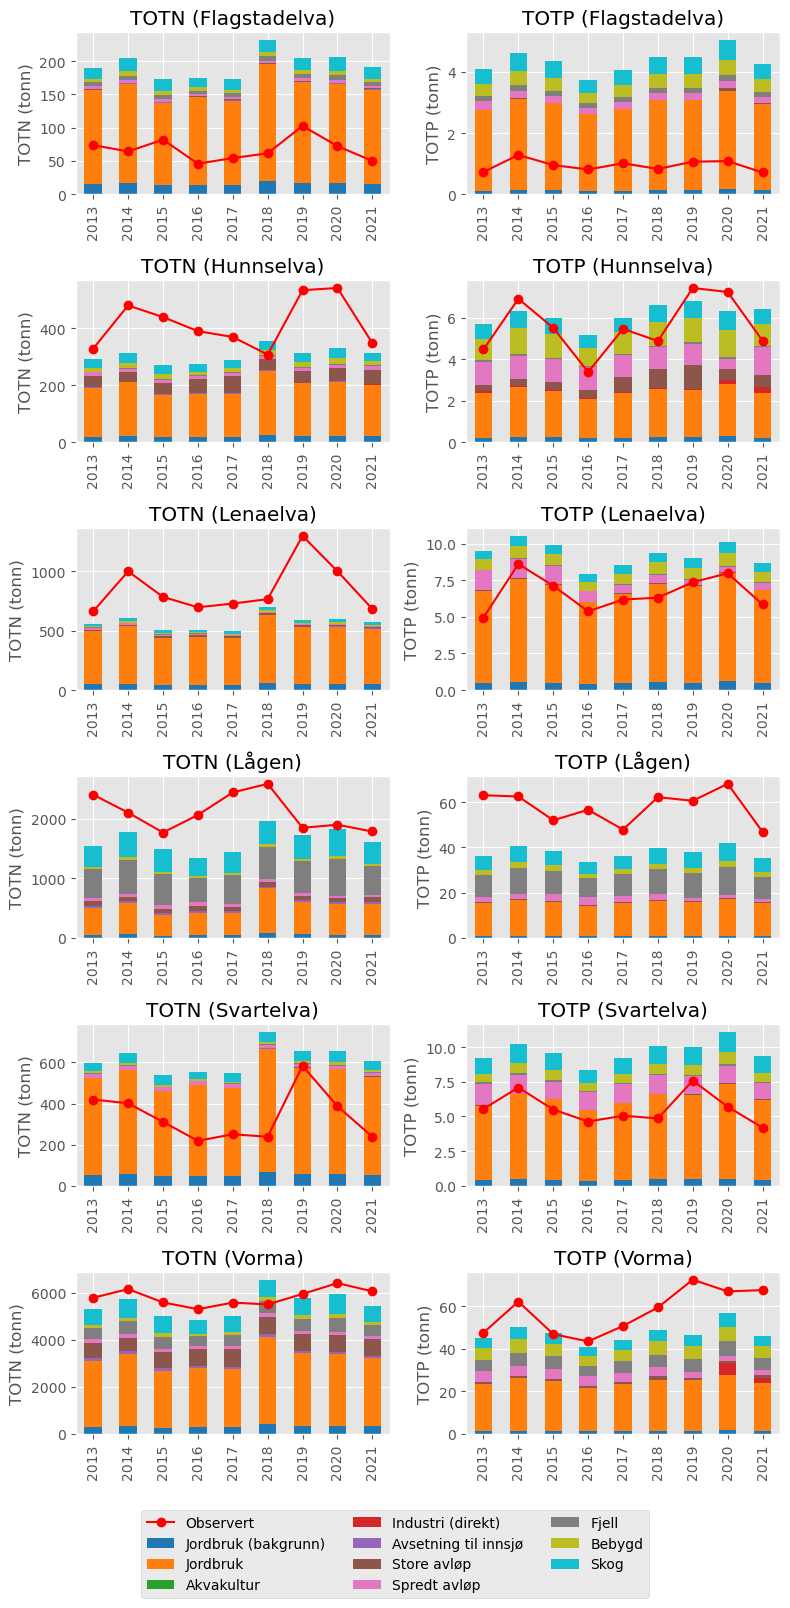

In [26]:
# Plot: single parameter per river
pars = ["TOTN", "TOTP"]
site_list = stn_df["site_id"].tolist()

fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(8, 15))

for row_idx, row in stn_df.iterrows():
    stn_id = row["site_id"]
    name = row["site_name"]
    stn_comp_df = comp_df.query("site_id == @stn_id")
    for col_idx, par in enumerate(pars):
        names_dict = {
            f"agriculture-background_{par.lower()}_tonnes": "Jordbruk (bakgrunn)",
            f"agriculture_{par.lower()}_tonnes": "Jordbruk",
            f"aquaculture_{par.lower()}_tonnes": "Akvakultur",
            f"industry_{par.lower()}_tonnes": "Industri (direkt)",
            f"lake_{par.lower()}_tonnes": "Avsetning til innsjø",
            f"large-wastewater_{par.lower()}_tonnes": "Store avløp",
            f"spredt_{par.lower()}_tonnes": "Spredt avløp",
            f"upland_{par.lower()}_tonnes": "Fjell",
            f"urban_{par.lower()}_tonnes": "Bebygd",
            f"wood_{par.lower()}_tonnes": "Skog",
        }
        par_cols = [
            col
            for col in stn_comp_df.columns
            if par.lower() in (i.lower() for i in col.split("_"))
        ]

        stn_comp_par_df = stn_comp_df.set_index("year")[par_cols]
        stn_comp_par_df.rename(columns=names_dict, inplace=True)
        stn_comp_par_df.drop(columns=[f"{par}_tonnes"]).plot(
            kind="bar",
            stacked=True,
            ax=axes[row_idx, col_idx],
            legend=False,
            cmap="tab10",
        )

        axes[row_idx, col_idx].plot(
            stn_comp_par_df.index - stn_comp_par_df.index.min(),
            stn_comp_par_df[f"{par}_tonnes"],
            marker="o",
            color="red",
            label="Observert",
        )
        axes[row_idx, col_idx].set_title(f"{par} ({name})")
        axes[row_idx, col_idx].set_ylabel(f"{par} (tonn)")
        axes[row_idx, col_idx].set_xlabel("")
plt.tight_layout()

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center", bbox_to_anchor=(0.5, -0.04), ncol=3)
plt.savefig("../../images/mjosa.png", dpi=200, bbox_inches="tight")

In [35]:
stn_comp_df = comp_df.query("site_id == 5")
par = 'TOTP'
par_cols = [
    col
    for col in stn_comp_df.columns
    if par.lower() in (i.lower() for i in col.split("_"))
]

stn_comp_par_df = stn_comp_df.set_index("year")[par_cols]
stn_comp_par_df

,TOTP_tonnes,agriculture-background_totp_tonnes,agriculture_totp_tonnes,aquaculture_totp_tonnes,industry_totp_tonnes,lake_totp_tonnes,large-wastewater_totp_tonnes,spredt_totp_tonnes,upland_totp_tonnes,urban_totp_tonnes,wood_totp_tonnes
year,,,,,,,,,,,
2013,63.085826,0.770940,14.665547,0.0,0.002082,0.0,0.334572,2.448317,9.701142,2.113600,5.991732
2014,62.528887,0.913900,15.782522,0.0,0.002082,0.0,0.346688,2.397991,11.497528,2.505619,7.101926
2015,52.020231,0.840694,15.048710,0.0,0.002082,0.0,0.463763,2.867831,10.579210,2.304509,6.534400
2016,56.647517,0.666130,13.647248,0.0,0.000208,0.0,0.439183,3.480598,8.380188,1.826575,5.175881
2017,47.903954,0.765361,14.584213,0.0,0.002290,0.0,0.464036,2.821921,9.628594,2.098219,5.947680
2018,62.222975,0.870567,15.364950,0.0,0.007598,0.0,0.443358,2.750613,10.954628,2.388163,6.766170
2019,60.638389,0.867804,15.203135,0.0,0.008222,0.0,0.411447,1.273188,10.918447,2.379688,6.743107
2020,68.132651,0.990884,16.150414,0.0,0.003435,0.0,0.642558,1.199917,12.467791,2.717227,7.700780
2021,46.904407,0.788728,14.499738,0.0,0.004163,0.0,0.717695,1.171004,9.923906,2.164017,6.129333
